In [3]:
import sys
sys.path.insert(1, '../')
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from agingml import temporal_degradation_test as tdt

/Users/santiago/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
n_simulations = 1000
n_prod = 12
dataset = 'avocados'
freq='W'
models =['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor', 'MLPRegressor']

In [8]:
model = models[1]
errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
d_errors_df = pd.read_parquet(f'../results/aging/{dataset}/aging_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

In [9]:
n_valid_models = errors_df[['simulation_id', 'is_model_valid']].drop_duplicates()['is_model_valid'].sum()
print(f"There are {n_valid_models} valid models out of {n_simulations} simulations.")

There are 971 valid models out of 1000 simulations.


In [10]:
test_errors_df = errors_df[errors_df['partition'] == 'test']
test_mape = test_errors_df.groupby('simulation_id').apply(lambda group: mean_absolute_percentage_error(group.y, group.y_pred))
test_mape = pd.DataFrame(test_mape, columns=['test_mape']).reset_index()

d_errors_df = pd.merge(d_errors_df, test_mape, how='left', on='simulation_id')

In [11]:
d_errors_df = d_errors_df[d_errors_df['test_mape'] <= 0.1]

In [12]:
trend_lines_df = tdt.get_trend_lines(data=d_errors_df, quantiles=[0.25, 0.50, 0.75], metric='error')

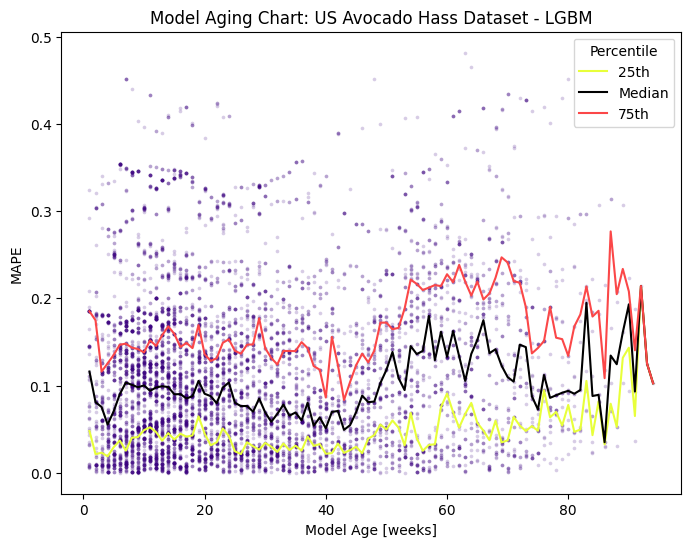

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data=trend_lines_df, x='model_age', y='error', linewidth=1.5,
             palette=['#E8FF3A', 'black', '#FB4748'], hue='quantile', legend=False, ax=ax)

sns.scatterplot(data=d_errors_df[d_errors_df['partition'] == 'prod'],
                x='model_age', y='error', s=7, alpha=0.20, color='#3b0280', linewidth=0, ax=ax)

ax.legend(title='Percentile', labels=['25th', 'Median', '75th'])
ax.set_xlabel('Model Age [weeks]')
ax.set_ylabel('MAPE')
# ax.set_ylim(0, 1)

ax.set_title('Model Aging Chart: US Avocado Hass Dataset - LGBM')
# plt.savefig('../figures/sketch_age_chart_calhouse_lgbm_MAPE.svg', format='svg')
plt.show()
